In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import time

In [3]:
df = pd.read_csv('intermediate-data/nfl_team_all_stats_2013_2022.csv', index_col=['Year', 'Team'])
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 320 entries, (2022, 'Seattle Seahawks') to (2021, 'Seattle Seahawks')
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MadePlayoffs                     320 non-null    float64
 1   QB_COST                          320 non-null    int64  
 2   RB_COST                          320 non-null    int64  
 3   WR_COST                          320 non-null    int64  
 4   TE_COST                          320 non-null    int64  
 5   OL_COST                          320 non-null    int64  
 6   Offense_COST                     320 non-null    int64  
 7   IDL_COST                         320 non-null    int64  
 8   EDGE_COST                        320 non-null    int64  
 9   LB_COST                          320 non-null    int64  
 10  S_COST                           320 non-null    int64  
 11  CB_COST                          320

In [ ]:
# dataset balance of subscribed class (derived from column '1 or 0').
df['MadePlayoffs'].value_counts()



MadePlayoffs
0.0    194
1.0    126
Name: count, dtype: int64

In [128]:
def encodeCategory(y) :
    """
    Encode the target category/class using a
    label encoder

    Args: 
        y: target category from data set
    
    Returns:
        y_encoded: encoded version of target category from data set
    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return y_encoded

def encodeDiscreteNumericCategory(y) :
    """
    Encode the target category/class using a
    label encoder

    Args: 
        y: target category from data set
    
    Returns:
        y_encoded: encoded version of target category from data set
    """
    le = OrdinalEncoder(dtype=np.int64)
    y_encoded = le.fit_transform(y)

    return pd.Series(y_encoded)

def createEncoderPreprocessor(scaler, feature_columns) :
    """
    use standard scaler to scale all features to unit variance

    Args:
        scaler: method used to scale data set (i.e. StandardScaler(), OrdinalEncoder)
        feature_columns: list of feature names
    
    Returns:
        transformer object containing the StandardScaler as the preprocessor
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('encoder', scaler, feature_columns)
        ])
    return preprocessor

# default encoder/scaler
ENCODER = StandardScaler()



In [ ]:
# get column names for target categories, off-stats, def-stats, off-cost, def-cost
target_categorical_columns = ['points_scored', 'points_allowed', 'score_differential', 'MadePlayoffs', 'wins', 'losses', 'ties']
off_cost_columns =  ['QB_COST', 'RB_COST', 'WR_COST', 'TE_COST', 'OL_COST', 'Offense_COST']
def_cost_columns = ['IDL_COST', 'EDGE_COST', 'LB_COST', 'S_COST', 'CB_COST', 'Defense_COST']
off_stats_columns = ['offense_completion_percentage', 'offense_total_yards_gained_pass', 'offense_total_yards_gained_run', 'offense_ave_yards_gained_pass', 'offense_ave_yards_gained_run', 'offense_total_air_yards', 'offense_ave_air_yards', 'offense_total_yac', 'offense_ave_yac', 'offense_n_plays_pass', 'offense_n_plays_run', 'offense_n_interceptions', 'offense_n_fumbles_lost_pass', 'offense_n_fumbles_lost_run', 'offense_total_epa_pass', 'offense_total_epa_run', 'offense_ave_epa_pass', 'offense_ave_epa_run', 'offense_total_wpa_pass', 'offense_total_wpa_run', 'offense_ave_wpa_pass', 'offense_ave_wpa_run', 'offense_success_rate_pass', 'offense_success_rate_run']
def_stats_columns = ['defense_completion_percentage', 'defense_total_yards_gained_pass', 'defense_total_yards_gained_run', 'defense_ave_yards_gained_pass', 'defense_ave_yards_gained_run', 'defense_total_air_yards', 'defense_ave_air_yards', 'defense_total_yac', 'defense_ave_yac', 'defense_n_plays_pass', 'defense_n_plays_run', 'defense_n_interceptions', 'defense_n_fumbles_lost_pass', 'defense_n_fumbles_lost_run', 'defense_total_epa_pass', 'defense_total_epa_run', 'defense_ave_epa_pass', 'defense_ave_epa_run', 'defense_total_wpa_pass', 'defense_total_wpa_run', 'defense_ave_wpa_pass', 'defense_ave_wpa_run', 'defense_success_rate_pass', 'defense_success_rate_run']

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_columns = df.drop(['points_scored', 'points_allowed', 'score_differential', 'MadePlayoffs', 'wins', 'losses', 'ties'], axis=1).columns.tolist()

# create training and test data frames where the training data is from the year prior to 2021 and
# test data is after 2020.

# target categories
# points_allowed_y_train = df.loc[:, ['points_allowed']].query('Year <= 2020')['points_allowed']
# points_allowed_y_test = df.loc[:, ['points_allowed']].query('Year > 2020')['points_allowed']

# points_scored_y_train = df.loc[:, ['points_scored']].query('Year <= 2020')['points_scored']
# points_scored_y_test = df.loc[:, ['points_scored']].query('Year > 2020')['points_scored']

score_diff_y_train = encodeDiscreteNumericCategory(df.loc[:, ['score_differential']].query('Year <= 2020')['score_differential'])
score_diff_y_test = encodeDiscreteNumericCategory(df.loc[:, ['score_differential']].query('Year > 2020')[['score_differential']])

wins_y_train = encodeDiscreteNumericCategory(df.loc[:, ['wins']].query('Year <= 2020')[['wins']])
wins_y_test = encodeDiscreteNumericCategory(df.loc[:, ['wins']].query('Year > 2020')[['wins']])

# feature data sets
# offcost_X_train = df.loc[:, off_cost_columns].query('Year <= 2020')
# offcost_X_test = df.loc[:, off_cost_columns].query('Year > 2020')

# defcost_X_train = df.loc[:, def_cost_columns].query('Year <= 2020')
# defcost_X_test = df.loc[:, def_cost_columns].query('Year > 2020')

# offstats_X_train = df.loc[:, off_stats_columns].query('Year <= 2020')
# offstats_X_test = df.loc[:, off_stats_columns].query('Year > 2020')

# defstats_X_train = df.loc[:, def_stats_columns].query('Year <= 2020')
# defstats_X_test = df.loc[:, def_stats_columns].query('Year > 2020')

# allcosts_X_train = df.loc[:, step1_target_list].query('Year <= 2020')
# allcosts_X_test = df.loc[:, step1_target_list].query('Year > 2020')

step1_target_list = off_stats_columns + def_stats_columns
allstats_X_train = df.loc[:, step1_target_list].query('Year <= 2020')
allstats_X_test = df.loc[:, step1_target_list].query('Year > 2020')

step2_target_list = off_stats_columns + def_stats_columns + list(['score_differential'])
score_diff_plus_stats_X_train = df.loc[:, step2_target_list].query('Year <= 2020')
score_diff_plus_stats_X_test = df.loc[:, step2_target_list].query('Year > 2020')



In [121]:
# Calculate the correlation between features
# and create a heat map from the results
def createCorrelationHeatMap(X, figsize) :
    corr = X.corr()

    # Generate the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black',
                xticklabels=corr.columns, yticklabels=corr.columns)  # Consider turning off annotations for speed
    plt.show()

def rmse(y_test, y_pred) :
    """
    get root mean squared error using test data and predicted results

    Args:
        y_test: target category from test data
        y_pred: predicted target catagory from test data

    Returns:
        float: root mean squared error (RMSE)
    """
    return np.sqrt(mean_squared_error(y_test, y_pred))

# create root mean squared error function as scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def calculatePermutationImportance(model_regressor, X_train, y_train, X_test, y_test, encoder=None) :
    """
    this calculates each feature's permutation-importance on the test data
    using a model regressor (i.e. RandomForestRegressor(n_estimators=100, random_state=42))
     
    NOTE: can be used to compare accuracy and correlation of features with permutation importance
    If high accuracy is observed with no features having importance there might be multicollinearity
    occuring within feature set.
     
    Return: Tuple {
                   data frame: containing importance score for each column in training/test data, 
                   float:      accuracy score from baseline prediction using model-regressor
                  }

    Args:
        model_regressor: type of model used for selecting features
        X_train: features from training data set
        y_train: category from training data set
        X_test: features from test data set
        y_test: category from test data set
        encoder: type of scaler/encoder to encoding the data set
    
    Returns:
        dict: list of features with importance value
        float: number of features
        float: score
        error: RMSE

    """
    # set encoder
    if (encoder == None):
        encoder = ENCODER # default

    pipe_model = Pipeline([('preprocessor', createEncoderPreprocessor(encoder, X_train.columns.tolist())),
                           ('regressor', model_regressor)
                        ])
    
    pipe_model.fit(X_train, y_train)
    score = pipe_model.score(X_test, y_test)
    y_pred = pipe_model.predict(X_test)
    error = rmse(y_test, y_pred)

    results = permutation_importance(pipe_model, X_test, y_test, n_repeats=10, n_jobs=-1, random_state=42)
    results_df = pd.DataFrame(data=results.importances_mean, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

    return results_df, len(results_df), score, error
    # for feature_name, importance_score in zip(X_train.columns, result.importances_mean) :


In [123]:
# evaluate features
# # offensive stats vs points scored
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             offstats_X_train, points_scored_y_train, offstats_X_test, points_scored_y_test
#                                         )
# # print(f'Feature Evaluation for [offensive stats vs points scored]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [offensive stats vs points scored]:\nAccuracy: {score}')

# # total stats vs points scored
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             allstats_X_train, points_scored_y_train, allstats_X_test, points_scored_y_test
#                                         )
# # print(f'Feature Evaluation for [total stats vs points scored]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [total stats vs points scored]:\nAccuracy: {score}')

# # defensive stats vs points allowed
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             defstats_X_train, points_allowed_y_train, defstats_X_test, points_allowed_y_test
#                                         )
# # print(f'Feature Evaluation for [defensive stats vs points allowed]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [defensive stats vs points allowed]:\nAccuracy: {score}')

# # total stats vs points scored
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             allstats_X_train, points_allowed_y_train, allstats_X_test, points_allowed_y_test
#                                         )
# # print(f'Feature Evaluation for [total stats vs points allowed]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [total stats vs points allowed]:\nAccuracy: {score}')

# # offensive stats vs points differential
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             offstats_X_train, score_diff_y_train, offstats_X_test, score_diff_y_test
#                                         )
# # print(f'Feature Evaluation for [offensive stats vs points differential]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [offensive stats vs points differential]:\nAccuracy: {score}')

# # defensive stats vs points differential
# selected_features, score = evaluateFeatures(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             defstats_X_train, score_diff_y_train, defstats_X_test, score_diff_y_test
#                                         )
# # print(f'Feature Evaluation for [defensive stats vs points differential]:\nAccuracy: {score}\n{selected_features.head(20)}')
# print(f'Feature Evaluation for [defensive stats vs points differential]:\nAccuracy: {score}')

########## USED in model
# all stats vs points differential
step1_perm_imp_selected_features, feature_cnt, score, error = calculatePermutationImportance(RandomForestRegressor(n_estimators=100, random_state=42),
                                            allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test
                                        )
# step1_perm_imp_selected_features, feature_cnt, score, error = calculatePermutationImportance(Lasso(alpha=1.0, fit_intercept=False, max_iter=10000, random_state=42),
#                                             allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test
#                                         )
print(f'STEP 1: Feature Evaluation for [total stats vs points differential]:\nAccuracy: feature-count: {feature_cnt}, {score}, RMSE: {error}\n{step1_perm_imp_selected_features}\n')
# print(f'STEP 1: Feature Evaluation using Lasso(L1) for [total stats vs points differential]:\nAccuracy: feature-count: {feature_cnt}, {score}, RMSE: {error}')

# # score-differential plus all stats vs points differential
# step2_perm_imp_selected_features, feature_cnt, score, error = calculatePermutationImportance(RandomForestRegressor(n_estimators=100, random_state=42),
#                                             score_diff_plus_stats_X_train, wins_y_train, score_diff_plus_stats_X_test, wins_y_test
#                                         )
# print(f'STEP 2: Feature Evaluation using RFR for [total stats vs points differential]:\nAccuracy: feature-count: {feature_cnt}, {score}, RMSE: {error}\n{step2_perm_imp_selected_features}\n')
# # print(f'STEP 2: Feature Evaluation for [total stats vs points differential]:\nAccuracy: feature-count: {feature_cnt}, {score}, RMSE: {error}')


c:\Users\steve\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


STEP 1: Feature Evaluation for [total stats vs points differential]:
Accuracy: feature-count: 48, -16.996730895594542, RMSE: 71.40514286887885
                                 Importance
offense_completion_percentage      0.532451
offense_ave_yac                    0.045033
defense_n_interceptions            0.038162
defense_ave_epa_run                0.026431
defense_total_yards_gained_run     0.019630
defense_ave_yac                    0.018872
offense_total_air_yards            0.014762
defense_n_fumbles_lost_run         0.013040
defense_total_wpa_run              0.007712
defense_success_rate_run           0.004093
offense_n_fumbles_lost_pass        0.003772
offense_n_fumbles_lost_run         0.003600
offense_ave_yards_gained_run       0.002277
defense_ave_yards_gained_run       0.001842
offense_ave_air_yards              0.001687
offense_total_wpa_run             -0.000724
offense_ave_wpa_run               -0.000778
defense_total_epa_run             -0.003116
defense_total_yards_g

In [ ]:
# top features from permutation-importance:
# STEP 1:
# offense_total_epa_pass             0.180254
# offense_ave_epa_pass               0.162008
# defense_ave_epa_pass               0.046784
# offense_ave_epa_run                0.015094
# defense_n_plays_run                0.010329
# offense_total_epa_run              0.010082

# STEP 2:
# score_differential                 1.297963
# offense_ave_wpa_pass               0.018817
# offense_total_wpa_pass             0.006737
# offense_ave_wpa_run                0.003654
# defense_completion_percentage      0.002384
# defense_ave_air_yards              0.001901
# offense_total_wpa_run              0.001602
# offense_ave_epa_pass               0.001579
# defense_ave_wpa_pass               0.001487
# offense_ave_epa_run                0.001154
# offense_total_epa_run              0.001116
# defense_n_fumbles_lost_run         0.001112
# offense_n_fumbles_lost_run         0.001033
# defense_total_wpa_run              0.000858
# offense_success_rate_run           0.000602
# offense_completion_percentage      0.000475
# offense_ave_yards_gained_run       0.000277
# defense_ave_wpa_run                0.000161
# defense_ave_epa_run                0.000126


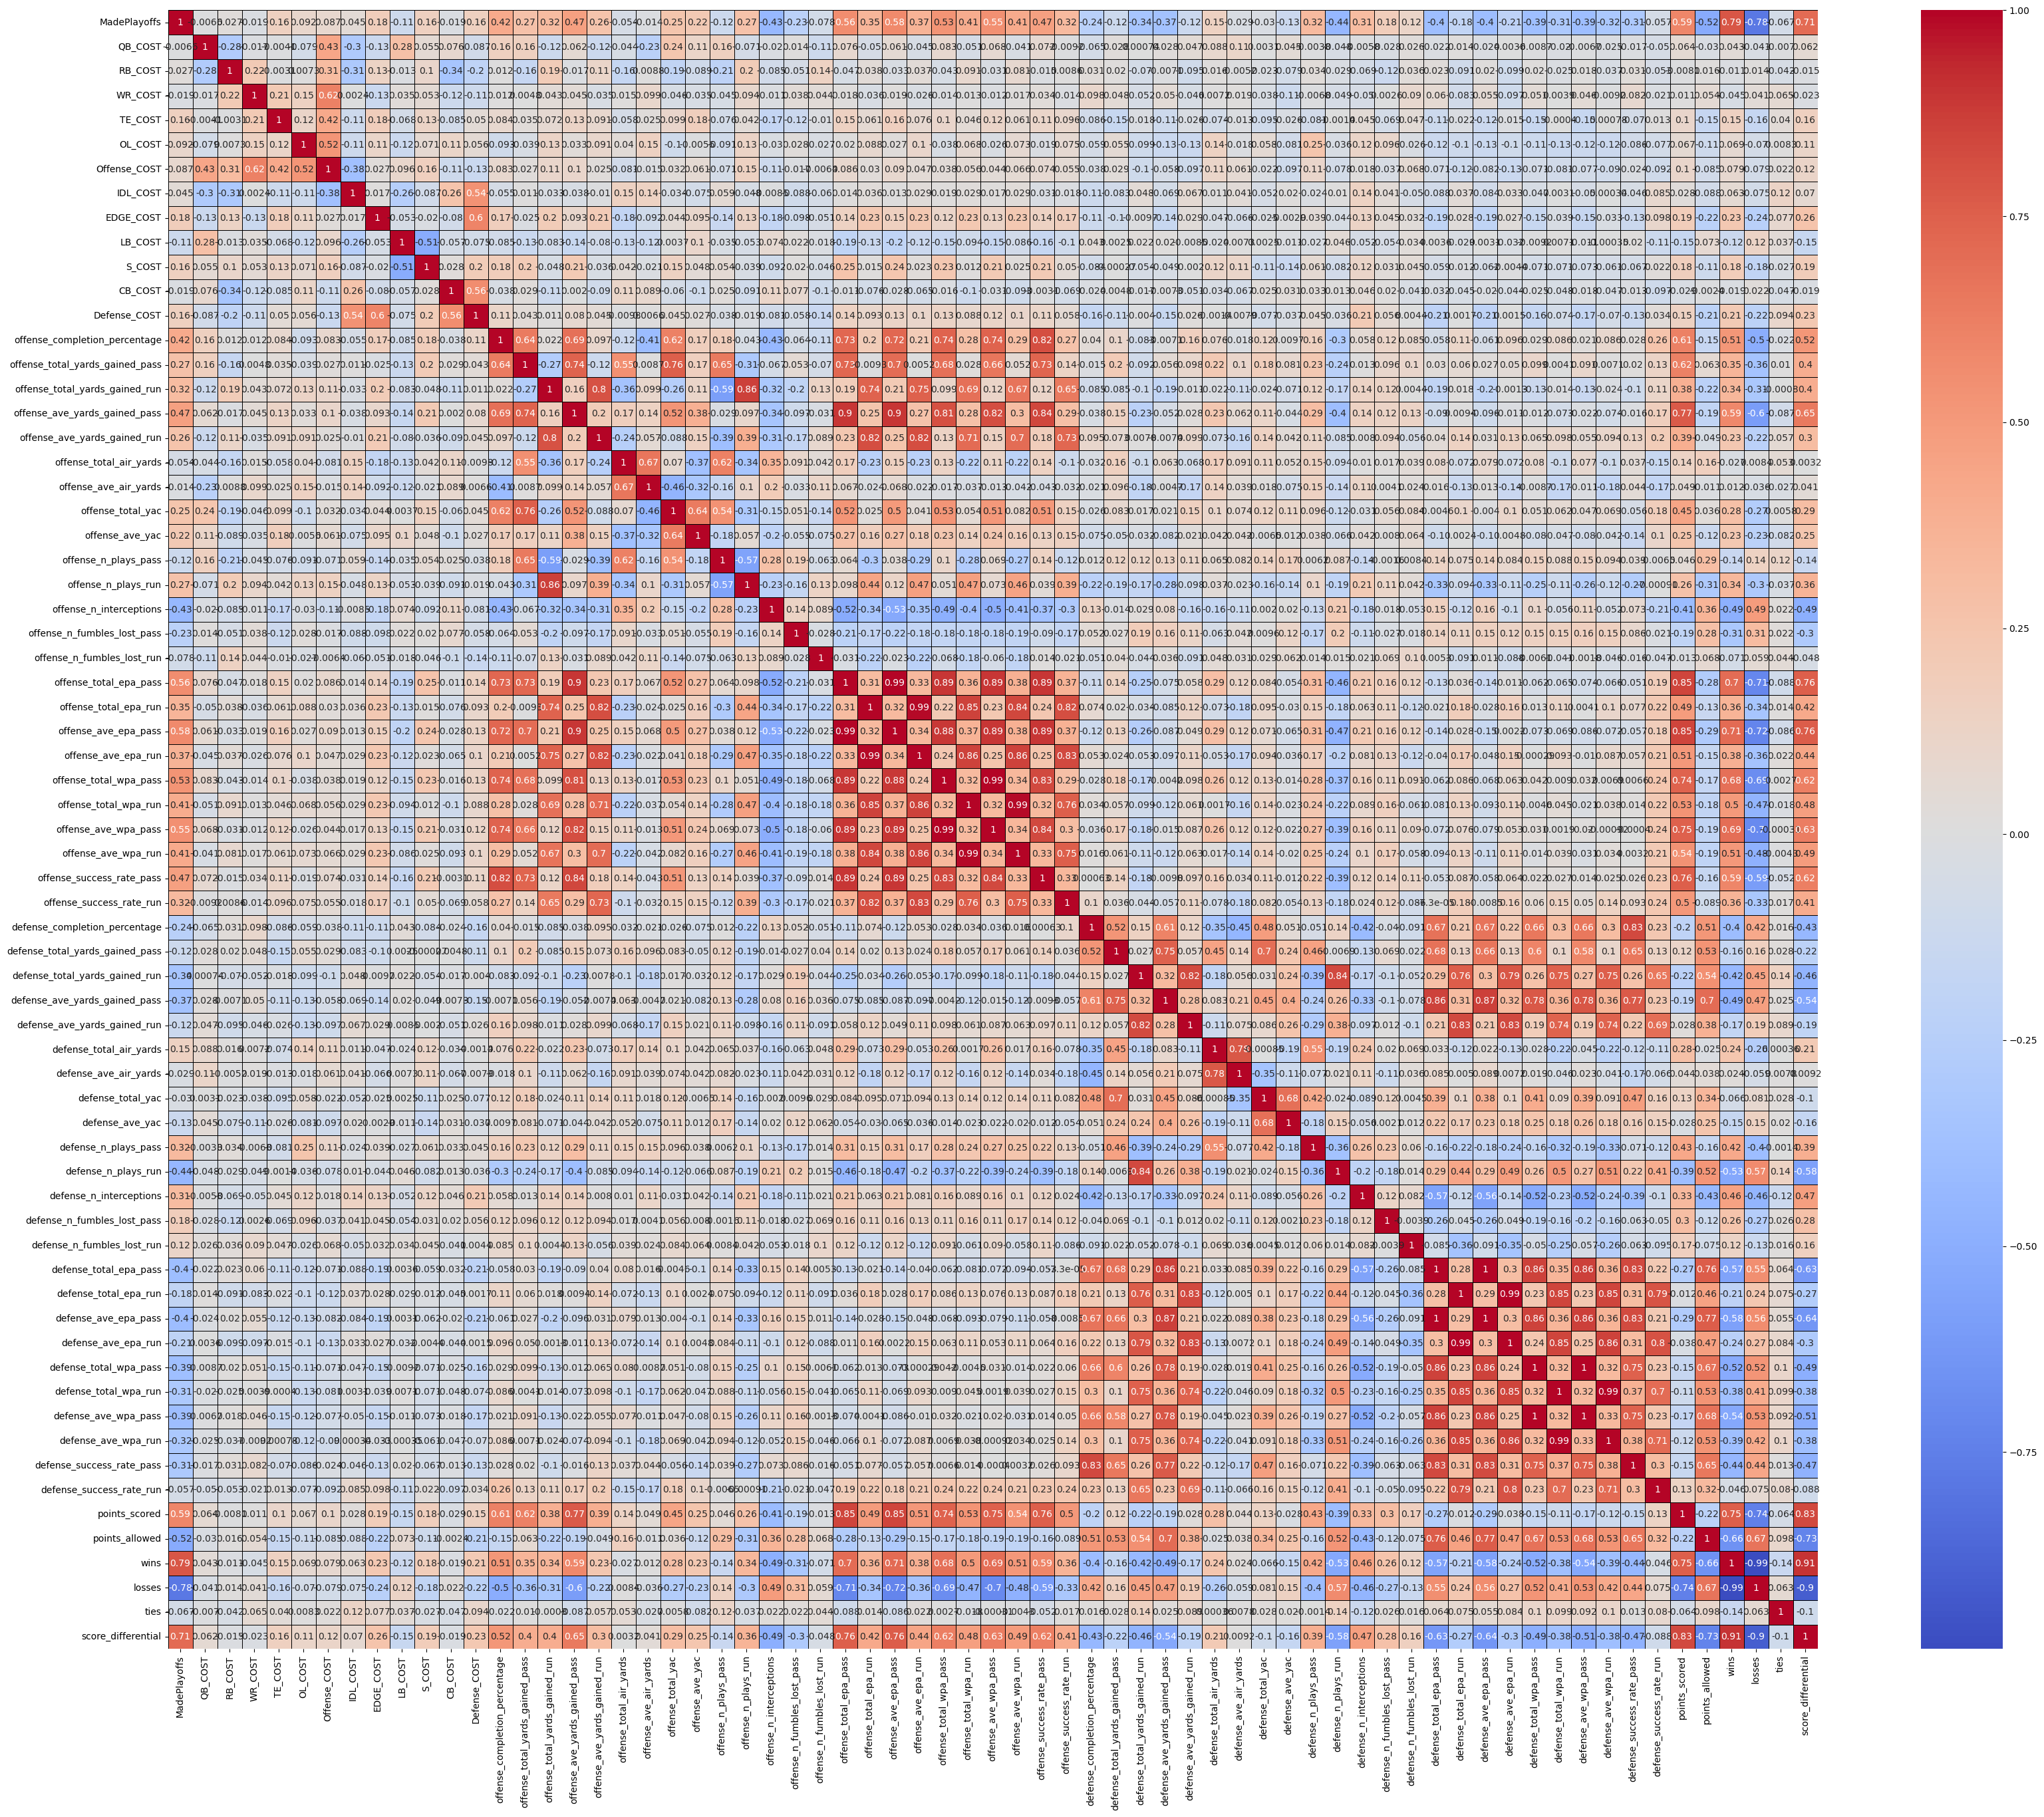

In [94]:

# Calculate the correlation matrix for the entire data set
createCorrelationHeatMap(X=df, figsize=(40, 32))


In [124]:
# Baseline Models:
models = {
    'knn-r': (KNeighborsRegressor()),
    'randomforest': (RandomForestRegressor()),
    'svr': (SVR()),
    'decisiontree-r': (DecisionTreeRegressor()),
    'ElasticNet': (ElasticNet(random_state=42)),
    'Ridge' : (Ridge(random_state=42)),
    'Lasso': (Lasso(random_state=42))
}

In [125]:
# Execute pipeline containing encoded data
# and target models with a custom scorer function
def executeModelsForBaselineEval(pipe_models, X_train, y_train, X_test, y_test, scorer_fx) :
    results = []
    for name, (model) in pipe_models.items():
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', createEncoderPreprocessor(ENCODER, X_train.columns.tolist())),
            (name, model)
        ])
        feature_cnt = len(X_train.columns.tolist())
        
        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1, scoring=scorer_fx)
        
        # Fit the model and time it
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
        
        # Get the best estimator
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        ## print("Best params: \n", grid_search.best_params_)
        # print("\nBest estimator: \n", grid_search.best_estimator_)
        
        # Evaluate on training and test sets
        train_score = best_model.score(X_train, y_train)
        test_score = best_model.score(X_test, y_test)

        # extract best root mean squared error
        best_rmse = -grid_search.best_score_
        print(f"best RMSE: {best_rmse}")
        
        # Append the results
        results.append([name + '-baseline', feature_cnt, best_params, train_score, test_score, best_rmse, fit_time])

    # Create the results DataFrame
    results_df = pd.DataFrame(results, columns=['model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time'])
    results_df.reset_index(inplace=True)

    return results_df


In [ ]:
# STEP 1: Feature Selection - get baseline using X training features allstats_X_train

# create baseline models for all-stats vs score differential
results_df = executeModelsForBaselineEval(models, allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test, rmse_scorer)

results_df.to_json('results/allstats_scorediff_baseline_model_results_df.json', orient='records', double_precision=10)

# baseline results
baseline_df = pd.read_json(r'results/allstats_scorediff_baseline_model_results_df.json')
baseline_df[['model', 'train score','test score', 'rmse','average fit time']]


In [50]:
# STEP 2: Feature Selection - get baseline using X training features score_diff_plus_stats_X_train

# create baseline models for all-stats vs score differential
results_df = executeModelsForBaselineEval(models, score_diff_plus_stats_X_train, wins_y_train, score_diff_plus_stats_X_test, wins_y_test, rmse_scorer)

results_df.to_json('results/score_diff_plus_stats_wins_baseline_model_results_df.json', orient='records', double_precision=10)

# baseline results
baseline_df = pd.read_json(r'results/score_diff_plus_stats_wins_baseline_model_results_df.json')
baseline_df[['model', 'train score','test score', 'rmse','average fit time']]

best RMSE: 1.4202503775215427
best RMSE: 1.2729561117096888
best RMSE: 1.3674522347792426
best RMSE: 1.787718761319804
best RMSE: 1.3729237803513663
best RMSE: 0.699508225382559
best RMSE: 1.5962296801672378


,model,train score,test score,rmse,average fit time
0,knn-r-baseline,0.854821,0.702867,1.420250,2.032179
1,randomforest-baseline,0.975412,0.764918,1.272956,2.174130
2,svr-baseline,0.907704,0.716636,1.367452,1.192791
3,decisiontree-r-baseline,1.000000,0.551586,1.787719,1.083280
4,ElasticNet-baseline,0.809947,0.789372,1.372924,0.027699
5,Ridge-baseline,0.965459,0.858263,0.699508,0.027849
6,Lasso-baseline,0.732604,0.679854,1.596230,0.027577


In [52]:
# create list of best coefficients
# Cs = np.logspace(-5, .5)
# Cs
    #    1.00000000e-05, 1.29492584e-05, 1.67683294e-05, 2.17137430e-05,
    #    2.81176870e-05, 3.64103195e-05, 4.71486636e-05, 6.10540230e-05,
    #    7.90604321e-05, 1.02377397e-04, 1.32571137e-04, 1.71669791e-04,
    #    2.22299648e-04, 2.87861559e-04, 3.72759372e-04, 4.82695744e-04,
    #    6.25055193e-04, 8.09400122e-04, 1.04811313e-03, 1.35722878e-03,
    #    1.75751062e-03, 2.27584593e-03, 2.94705170e-03, 3.81621341e-03,
    #    4.94171336e-03, 6.39915234e-03, 8.28642773e-03, 1.07303094e-02,
    #    1.38949549e-02, 1.79929362e-02, 2.32995181e-02, 3.01711481e-02,
    #    3.90693994e-02, 5.05919749e-02, 6.55128557e-02, 8.48342898e-02,
    #    1.09854114e-01, 1.42252931e-01, 1.84206997e-01, 2.38534401e-01,
    #    3.08884360e-01, 3.99982340e-01, 5.17947468e-01, 6.70703561e-01,
    #    8.68511374e-01, 1.12465782e+00, 1.45634848e+00, 1.88586328e+00,
    #    2.44205309e+00, 3.16227766e+00

# randomely selected 6 of the 50 coefficients
Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]

In [ ]:
# Lasso regressor - feature selection using L1 as penalty

def createCoefToFeatureListUsingLasso(X_train, y_train, coefseeds) :
    """
    built convergence table to see what were, optimally, the best features.
        ...the information from this effort matched the output from the SelectFromModel() which, in the end, what was eventually used.

        Args:
            X_train : X features from training data set
            y_train : target category from training data set
            coefseed : list of coeficients

        Returns:
            dict: containing coeficient for each feature by coefseed
    """
    coef_list = []
    for C in coefseeds:
        pipeline = Pipeline([
                ('preprocessor', createEncoderPreprocessor(X_train.columns.tolist())),
                ('model', Lasso(max_iter=10000, tol=C, random_state=42))
            ])
        
        model_grid = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1, scoring=rmse_scorer)
        model_grid.fit(X_train, y_train)

        coef_list.append(list(model_grid.best_estimator_.named_steps['ElasticNet'].coef_))
    
    coef_df = pd.DataFrame(data=coef_list, columns=X_train.columns)
    coef_df.index = coefseeds
    return coef_df

# STEP 1: Feature Selection: create coeficients
print("STEP 1: Feature selection - generating coeficients")
optimal_features_df = createCoefToFeatureListUsingLasso(allstats_X_train, score_diff_y_train, Cs)
optimal_features_df


STEP 1: Feature selection - generating coeficients


,offense_completion_percentage,offense_total_yards_gained_pass,offense_total_yards_gained_run,offense_ave_yards_gained_pass,offense_ave_yards_gained_run,offense_total_air_yards,offense_ave_air_yards,offense_total_yac,offense_ave_yac,offense_n_plays_pass,...,defense_total_epa_pass,defense_total_epa_run,defense_ave_epa_pass,defense_ave_epa_run,defense_total_wpa_pass,defense_total_wpa_run,defense_ave_wpa_pass,defense_ave_wpa_run,defense_success_rate_pass,defense_success_rate_run
0.000010,2.690424,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.538851,-0.000000,-0.000000,0.000000,...,-26.037159,-8.163493,-20.116827,-0.0,0.000000,-6.240934,0.000000,-3.141139,-0.000000,-0.000000
0.000809,2.506686,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.569986,-0.000000,-0.000000,0.000000,...,-39.421105,-8.325405,-6.885766,-0.0,0.000000,-9.046739,0.000000,-0.072775,-0.000000,-0.000000
0.002276,2.418466,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.565380,-0.000000,-0.000000,0.000000,...,-45.512946,-8.796257,-1.000563,-0.0,0.000000,-8.693810,0.000000,-0.000000,-0.000000,-0.000000
0.065513,0.710312,4.192333,-0.000000,6.874945,-0.000000,0.000000,-0.326227,0.159039,-0.000000,0.459032,...,-32.833104,-9.038127,-0.033198,-0.0,0.000000,-4.901700,0.000000,-0.000000,-0.000000,-0.000000
0.517947,42.862720,12.620513,24.383949,7.155760,-1.977979,13.449396,5.260484,-0.000000,7.549470,-3.939446,...,-1.529198,-0.000000,-0.012026,-0.0,1.573564,-0.031112,0.014689,-0.022641,3.681719,-1.083789
3.162278,50.099453,3.191886,39.032318,13.358501,-11.723776,10.266405,8.739795,-0.000000,11.453655,-7.878600,...,-0.000000,0.000000,-0.000000,0.0,1.269565,-0.000000,0.015502,-0.000000,1.980953,-2.220554


In [ ]:
# ElasticNet regressor - feature selection using L1 as penalty

def createCoefToFeatureListUsingElasticNet(X_train, y_train, coefseeds) :
    """
    built convergence table to see what were, optimally, the best features.
        ...the information from this effort matched the output from the SelectFromModel() which, in the end, what was eventually used.

        Args:
            X_train : X features from training data set
            y_train : target category from training data set
            coefseed : list of coeficients

        Returns:
            dict: containing coeficient for each feature by coefseed
    """
    # Perform grid search
    coef_list = []
    for C in coefseeds:
        pipeline = Pipeline([
                ('preprocessor', createEncoderPreprocessor(X_train.columns.tolist())),
                ('model', ElasticNet(tol=C, random_state=42))
            ])
        
        model_grid = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1, scoring=rmse_scorer)
        model_grid.fit(X_train, y_train)

        coef_list.append(list(model_grid.best_estimator_.named_steps['ElasticNet'].coef_))
    
    coef_df = pd.DataFrame(data=coef_list, columns=X_train.columns)
    coef_df.index = coefseeds
    return coef_df

# STEP 2: Feature Selection: create coeficients
optimal_features_df = createCoefToFeatureListUsingElasticNet(score_diff_plus_stats_X_train, wins_y_train, Cs)

print("STEP 2: Feature selection - generating coeficients")
optimal_features_df


STEP 2: Feature selection - generating coeficients


,offense_completion_percentage,offense_total_yards_gained_pass,offense_total_yards_gained_run,offense_ave_yards_gained_pass,offense_ave_yards_gained_run,offense_total_air_yards,offense_ave_air_yards,offense_total_yac,offense_ave_yac,offense_n_plays_pass,...,defense_total_epa_run,defense_ave_epa_pass,defense_ave_epa_run,defense_total_wpa_pass,defense_total_wpa_run,defense_ave_wpa_pass,defense_ave_wpa_run,defense_success_rate_pass,defense_success_rate_run,score_differential
0.000010,0.00000,0.0,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,-0.000000,...,-0.0,-0.094493,-0.0,-0.222509,-0.070615,-0.239680,-0.098062,-0.0,-0.0,0.782562
0.000809,0.00000,0.0,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,-0.000000,...,-0.0,-0.094886,-0.0,-0.222980,-0.070971,-0.239561,-0.098000,-0.0,-0.0,0.781790
0.002276,0.00000,0.0,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,-0.000000,...,-0.0,-0.095116,-0.0,-0.222434,-0.070636,-0.238264,-0.097685,-0.0,-0.0,0.781673
0.065513,0.00000,0.0,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,-0.000000,...,-0.0,-0.096327,-0.0,-0.235409,-0.076092,-0.264441,-0.106652,-0.0,-0.0,0.779440
0.517947,0.00000,-0.0,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,-0.000000,...,-0.0,-0.200257,-0.0,-0.283332,-0.146140,-0.184657,-0.088182,-0.0,-0.0,0.493482
3.162278,0.68808,0.0,0.454139,0.445086,0.0,-0.0,0.0,0.0,0.0,-0.003575,...,-0.0,-0.051505,-0.0,-0.107360,-0.048103,-0.028031,-0.016687,-0.0,-0.0,0.069889


In [ ]:
features_list = optimal_features_df.columns.to_list()
print ('List of all features found in baseline DataFrame')
features_list

# # display the best features
# column_list = []
# for idx in range(len(features_list)) :
#     column_list.append(features_list[idx])

#     if len(column_list) == 5 :
#         plt.figure(figsize = (12, 5))
#         plt.semilogx(optimal_features_df.loc[:, column_list])
#         plt.gca().invert_xaxis()
#         plt.grid()
#         plt.legend(column_list);
#         plt.title('NFL league statistics Features')
#         plt.xlabel("Increasing 1/C")
#         plt.savefig('images/best_lr_features_using_coef_l1_' + str(idx) + '.png')

#         column_list = []

In [55]:
# Use SelectFromModel to get the best features for the following coefficients defined previously in Cs variable
# Cs = [1.00000000e-05, 8.09400122e-04, 2.27584593e-03, 6.55128557e-02, 5.17947468e-01, 3.16227766e+00]

def createSelectedFeatureList(X_train, y_train, Cs) :
    """
    Use SelectFromModel to get the best features for the following coefficients defined previously in Cs variable

    Args:
        X_train: feature set from training data
        y_train: target catagories/classes from training data
        Cs: list of coeficients
    
    Returns:
        dict: list of selected features by coeficient
    """
    lasso_sf_results = {}
    for tolerance in Cs:
        selector = SelectFromModel(Lasso(max_iter=10000, tol=tolerance, random_state=42))
        ans = selector.fit_transform(X_train, y_train)
        selected_features = selector.get_feature_names_out()

        # create data dictionary of coefficients associated with its target feature set
        lasso_sf_results[tolerance] = selected_features
        
        print("C: ", tolerance, ' , Feature set: ', selected_features)  # get best feature names that converged

    return lasso_sf_results

def ndarray_to_list(obj):
    """
    Converts ndarray objects to lists for JSON serialization.

    Args:
        obj: Any object.

    Returns:
        The object converted to a list if it's an ndarray, otherwise the original object.
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")



In [ ]:
# STEP 1: Feature Selection: save data dictionary of coefficients and features to file

selected_feature_results = createSelectedFeatureList(allstats_X_train, score_diff_y_train, Cs)

with open('features/allstats_scorediff_lasso_selected_feature_results.json', 'w') as fp:
    json.dump(selected_feature_results, fp, sort_keys=True, default=ndarray_to_list)


In [ ]:
# STEP 2: Feature Selection: save data dictionary of coefficients and features to file

selected_feature_results = createSelectedFeatureList(allstats_X_train, score_diff_y_train, Cs)

with open('features/allstats_scorediff_lasso_selected_feature_results.json', 'w') as fp:
    json.dump(selected_feature_results, fp, sort_keys=True, default=ndarray_to_list)



In [18]:
def load_map_from_json(file_path):
    """
    Loads a map (dictionary) from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The map loaded from the JSON file, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
         print(f"An unexpected error occurred: {e}")
         return None

In [ ]:
def scoreLassoModel(X_train, y_train, X_test, y_test, selected_features_map, scorer_fx, json_file_path) : 
    """
    Score Lasso models with new hyperparameters while using coefficients and features from data dictionary saved in previous step.
    The results are save to file where the file contains a map of the best model, tolerance (coeficient), list of features, scores and 
    average fit time in JSON format.

    Args:
        X_train (DataFrame): feature training data
        y_train (Series): target training categories
        X_test (DataFrame): feature test data
        y_test (Series): target test categories
        selected_feature_results (DataFrame): feature list and corresponding 'tolerance coeficient' value
        scorer_fx: custom fx scorer used in GridSearchCV for performing custom error calculations (i.e. calculating RMSE)
        json_file_path: file-path where results get stored

    Returns:
        dict: best Lasso models by tolerance
    """
    best_model_results = []
    best_models_df = {}
    for tolerance, selected_feature_list in selected_features_map.items() :
        hyperparams = {
                'model__selection': ['cyclic', 'random'],
                'model__fit_intercept': [True, False]
            }
        # preprocessor = ColumnTransformer(
        #     transformers=[
        #         ('selected_features', StandardScaler(), selected_feature_list),
        #     ])
        model_pipe = Pipeline([
                            ('preprocessor', createEncoderPreprocessor(selected_feature_list)),
                            ('model', Lasso(alpha=1.0, tol=float(tolerance), max_iter=10000, random_state=42))
                        ])
        model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=10, n_jobs=-1, scoring=scorer_fx)
        
        start_time = time.time()
        model_grid.fit(X_train[selected_feature_list], y_train)
        fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time'])

        # Get the best estimator and best root mean squared error (RMSE)
        best_model = model_grid.best_estimator_
        best_rmse = -model_grid.best_score_
        print(f"Coef: {tolerance}, Best params: {model_grid.best_params_}")
        # print('Best estimator: ', model_grid.best_estimator_)

        best_models_df[tolerance] = best_model

        train_score = best_model.score(X_train[selected_feature_list], y_train)
        test_score = best_model.score(X_test[selected_feature_list], y_test)
        # print(f"Coef:{tolerance}, features {len(selected_feature_list)}: {selected_feature_list}")

        best_model_results.append([float(tolerance), 'Lasso', len(selected_feature_list), model_grid.best_params_, train_score, test_score, best_rmse, fit_time])

    best_model_results_df = pd.DataFrame(best_model_results, columns=['coef', 'model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time'])
    best_model_results_df.reset_index(inplace=True)
    best_model_results_df.to_json(json_file_path, orient='records', double_precision=10)

    return best_models_df

In [20]:
# load data dictionary with selected features and matching coefficients
selected_features_map = load_map_from_json('features/allstats_scorediff_lasso_selected_feature_results.json')
# selected_features_map

results_df = scoreLassoModel(allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test, selected_features_map, rmse_scorer, 'results/allstats_scorediff_lasso_model_results_df.json')

Coef: 1e-05, Best params: {'model__fit_intercept': False, 'model__selection': 'cyclic'}
Coef: 0.000809400122, Best params: {'model__fit_intercept': False, 'model__selection': 'random'}
Coef: 0.00227584593, Best params: {'model__fit_intercept': False, 'model__selection': 'cyclic'}
Coef: 0.0655128557, Best params: {'model__fit_intercept': False, 'model__selection': 'cyclic'}
Coef: 0.517947468, Best params: {'model__fit_intercept': False, 'model__selection': 'random'}
Coef: 3.16227766, Best params: {'model__fit_intercept': True, 'model__selection': 'random'}


In [21]:
lr_results_df = pd.read_json('results/allstats_scorediff_lasso_model_results_df.json')
lr_results_df

,index,coef,model,feature count,best params,train score,test score,rmse,average fit time
0,0,0.000010,Lasso,22,"{'model__fit_intercept': False, 'model__select...",0.948095,0.926080,23.431637,0.776720
1,1,0.000809,Lasso,23,"{'model__fit_intercept': False, 'model__select...",0.948168,0.925834,23.526560,0.022554
2,2,0.002276,Lasso,23,"{'model__fit_intercept': False, 'model__select...",0.948150,0.926003,23.532956,0.022542
3,3,0.065513,Lasso,23,"{'model__fit_intercept': False, 'model__select...",0.941973,0.911902,25.027700,0.020070
4,4,0.517947,Lasso,30,"{'model__fit_intercept': False, 'model__select...",0.914425,0.854293,29.951857,0.022648
5,5,3.162278,Lasso,34,"{'model__fit_intercept': True, 'model__selecti...",0.831136,0.764068,41.625282,0.024394


In [ ]:
def scoreRidgeModel(X_train, y_train, X_test, y_test, selected_features_map, scorer_fx, json_file_path) : 
    """
    Score Ridge models with new hyperparameters while using coefficients and features from data dictionary saved in previous step.
    The results are save to file where the file contains a map of the best model, tolerance (coeficient), list of features, scores and 
    average fit time in JSON format.

    Args:
        X_train (DataFrame): feature training data
        y_train (Series): target training categories
        X_test (DataFrame): feature test data
        y_test (Series): target test categories
        selected_feature_results (DataFrame): feature list and corresponding 'tolerance coeficient' value
        scorer_fx: custom fx scorer used in GridSearchCV for performing custom error calculations (i.e. calculating RMSE)
        json_file_path: file-path where results get stored

    Returns:
        dict: best Ridge models by tolerance
    """
    best_model_results = []
    best_models_df = {}
    for tolerance, selected_feature_list in selected_features_map.items() :
        hyperparams = {
                'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                'model__fit_intercept': [True, False]
            }
        # preprocessor = ColumnTransformer(
        #     transformers=[
        #         ('selected_features', StandardScaler(), selected_feature_list),
        #     ])
        model_pipe = Pipeline([
                            ('preprocessor', createEncoderPreprocessor(selected_feature_list)),
                            ('model', Ridge(alpha=1.0, tol=float(tolerance), max_iter=10000, random_state=42))
                        ])
        model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=10, n_jobs=-1, scoring=scorer_fx)
        
        start_time = time.time()
        model_grid.fit(X_train[selected_feature_list], y_train)
        fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time'])

        # Get the best estimator and best root mean squared error (RMSE)
        best_model = model_grid.best_estimator_
        best_rmse = -model_grid.best_score_
        print(f"Coef: {tolerance}, Best params: {model_grid.best_params_}")
        # print('Best estimator: ', model_grid.best_estimator_)

        best_models_df[tolerance] = best_model

        train_score = best_model.score(X_train[selected_feature_list], y_train)
        test_score = best_model.score(X_test[selected_feature_list], y_test)
        # print(f"Coef:{tolerance}, features {len(selected_feature_list)}: {selected_feature_list}")

        best_model_results.append([float(tolerance), 'Ridge', len(selected_feature_list), model_grid.best_params_, train_score, test_score, best_rmse, fit_time])

    best_model_results_df = pd.DataFrame(best_model_results, columns=['coef', 'model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time'])
    best_model_results_df.reset_index(inplace=True)
    best_model_results_df.to_json(json_file_path, orient='records', double_precision=10)

    return best_models_df

In [23]:
# load data dictionary with selected features and matching coefficients
selected_features_map = load_map_from_json('features/allstats_scorediff_lasso_selected_feature_results.json')
# selected_features_map

results_df = scoreRidgeModel(allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test, selected_features_map, rmse_scorer, 'results/allstats_scorediff_ridge_model_results_df.json')

Coef: 1e-05, Best params: {'model__fit_intercept': False, 'model__solver': 'saga'}
Coef: 0.000809400122, Best params: {'model__fit_intercept': False, 'model__solver': 'auto'}
Coef: 0.00227584593, Best params: {'model__fit_intercept': False, 'model__solver': 'auto'}
Coef: 0.0655128557, Best params: {'model__fit_intercept': False, 'model__solver': 'auto'}
Coef: 0.517947468, Best params: {'model__fit_intercept': False, 'model__solver': 'auto'}
Coef: 3.16227766, Best params: {'model__fit_intercept': False, 'model__solver': 'auto'}


In [24]:
rr_results_df = pd.read_json('results/allstats_scorediff_ridge_model_results_df.json')
rr_results_df

,index,coef,model,feature count,best params,train score,test score,rmse,average fit time
0,0,0.000010,Ridge,22,"{'model__fit_intercept': False, 'model__solver...",0.952249,0.916442,23.483415,0.020341
1,1,0.000809,Ridge,23,"{'model__fit_intercept': False, 'model__solver...",0.952221,0.915776,23.608793,0.016399
2,2,0.002276,Ridge,23,"{'model__fit_intercept': False, 'model__solver...",0.952221,0.915776,23.608793,0.019828
3,3,0.065513,Ridge,23,"{'model__fit_intercept': False, 'model__solver...",0.952221,0.915776,23.608793,0.018242
4,4,0.517947,Ridge,30,"{'model__fit_intercept': False, 'model__solver...",0.952289,0.920360,24.117570,0.018974
5,5,3.162278,Ridge,34,"{'model__fit_intercept': False, 'model__solver...",0.953614,0.922417,24.195568,0.018854


In [ ]:
def scoreElasticNetModel(X_train, y_train, X_test, y_test, selected_features_map, scorer_fx, json_file_path) : 
    """
    Score ElasticNet models with new hyperparameters while using coefficients and features from data dictionary saved in previous step.
    The results are save to file where the file contains a map of the best model, tolerance (coeficient), list of features, scores and 
    average fit time in JSON format.

    Args:
        X_train (DataFrame): feature training data
        y_train (Series): target training categories
        X_test (DataFrame): feature test data
        y_test (Series): target test categories
        selected_feature_results (DataFrame): feature list and corresponding 'tolerance coeficient' value
        scorer_fx: custom fx scorer used in GridSearchCV for performing custom error calculations (i.e. calculating RMSE)
        json_file_path: file-path where results get stored

    Returns:
        dict: best ElasticNet models by tolerance
    """
    best_model_results = []
    best_models_df = {}
    for tolerance, selected_feature_list in selected_features_map.items() :
        hyperparams = {
                'model__selection': ['cyclic', 'random'],
                'model__fit_intercept': [True, False],
                'model__l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            }
        # preprocessor = ColumnTransformer(
        #     transformers=[
        #         ('selected_features', StandardScaler(), selected_feature_list),
        #     ])
        model_pipe = Pipeline([
                            ('preprocessor', createEncoderPreprocessor(selected_feature_list)),
                            ('model', ElasticNet(alpha=1.0, tol=float(tolerance), max_iter=10000, random_state=42))
                        ])
        model_grid = GridSearchCV(model_pipe, param_grid=hyperparams, cv=10, n_jobs=-1, scoring=scorer_fx)
        
        start_time = time.time()
        model_grid.fit(X_train[selected_feature_list], y_train)
        fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time'])

        # Get the best estimator and best root mean squared error (RMSE)
        best_model = model_grid.best_estimator_
        best_rmse = -model_grid.best_score_
        print(f"Coef: {tolerance}, Best params: {model_grid.best_params_}")
        # print('Best estimator: ', model_grid.best_estimator_)

        best_models_df[tolerance] = best_model

        train_score = best_model.score(X_train[selected_feature_list], y_train)
        test_score = best_model.score(X_test[selected_feature_list], y_test)
        # print(f"Coef:{tolerance}, features {len(selected_feature_list)}: {selected_feature_list}")

        best_model_results.append([float(tolerance), 'Elastic Net', len(selected_feature_list), model_grid.best_params_, train_score, test_score, best_rmse, fit_time])

    best_model_results_df = pd.DataFrame(best_model_results, columns=['coef', 'model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time'])
    best_model_results_df.reset_index(inplace=True)
    best_model_results_df.to_json(json_file_path, orient='records', double_precision=10)

    return best_models_df

In [26]:
# load data dictionary with selected features and matching coefficients
selected_features_map = load_map_from_json('features/allstats_scorediff_lasso_selected_feature_results.json')
# selected_features_map

results_df = scoreElasticNetModel(allstats_X_train, score_diff_y_train, allstats_X_test, score_diff_y_test, selected_features_map, rmse_scorer, 'results/allstats_scorediff_elastic_net_model_results_df.json')

Coef: 1e-05, Best params: {'model__fit_intercept': False, 'model__l1_ratio': 1.0, 'model__selection': 'cyclic'}
Coef: 0.000809400122, Best params: {'model__fit_intercept': False, 'model__l1_ratio': 1.0, 'model__selection': 'random'}
Coef: 0.00227584593, Best params: {'model__fit_intercept': False, 'model__l1_ratio': 1.0, 'model__selection': 'cyclic'}
Coef: 0.0655128557, Best params: {'model__fit_intercept': False, 'model__l1_ratio': 1.0, 'model__selection': 'cyclic'}
Coef: 0.517947468, Best params: {'model__fit_intercept': False, 'model__l1_ratio': 0.5, 'model__selection': 'cyclic'}
Coef: 3.16227766, Best params: {'model__fit_intercept': True, 'model__l1_ratio': 0.6, 'model__selection': 'random'}


In [27]:
en_results_df = pd.read_json('results/allstats_scorediff_elastic_net_model_results_df.json')
en_results_df

,index,coef,model,feature count,best params,train score,test score,rmse,average fit time
0,0,0.000010,Elastic Net,22,"{'model__fit_intercept': False, 'model__l1_rat...",0.948095,0.926080,23.431637,0.017170
1,1,0.000809,Elastic Net,23,"{'model__fit_intercept': False, 'model__l1_rat...",0.948168,0.925834,23.526560,0.017043
2,2,0.002276,Elastic Net,23,"{'model__fit_intercept': False, 'model__l1_rat...",0.948150,0.926003,23.532956,0.017166
3,3,0.065513,Elastic Net,23,"{'model__fit_intercept': False, 'model__l1_rat...",0.941973,0.911902,25.027700,0.017044
4,4,0.517947,Elastic Net,30,"{'model__fit_intercept': False, 'model__l1_rat...",0.916474,0.887664,28.985778,0.012627
5,5,3.162278,Elastic Net,34,"{'model__fit_intercept': True, 'model__l1_rati...",0.847598,0.764611,38.867993,0.012365


In [44]:
# load results from files for comparison
baseline_results_df = pd.read_json('results/allstats_scorediff_baseline_model_results_df.json')
lasso_results_df = pd.read_json('results/allstats_scorediff_lasso_model_results_df.json')
ridge_results_df = pd.read_json('results/allstats_scorediff_ridge_model_results_df.json')
elasticnet_results_df = pd.read_json('results/allstats_scorediff_elastic_net_model_results_df.json')

# round and sort by 'test score' and 'average fit time' columns, putting the best results at the top
finale_model_results_df = pd.concat([baseline_results_df, lasso_results_df, ridge_results_df, elasticnet_results_df]).round(decimals={'test score':2, 'rmse':3, 'average fit time':3})

# set column order
column_order = ['coef', 'model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time']
finale_model_results_df =  finale_model_results_df.reindex(columns=column_order).sort_values(by=['test score', 'rmse', 'average fit time'], ascending=[False, True, True])

finale_model_results_df

,coef,model,feature count,best params,train score,test score,rmse,average fit time
0,0.000010,Elastic Net,22,"{'model__fit_intercept': False, 'model__l1_rat...",0.948095,0.93,23.432,0.017
0,0.000010,Lasso,22,"{'model__fit_intercept': False, 'model__select...",0.948095,0.93,23.432,0.777
1,0.000809,Elastic Net,23,"{'model__fit_intercept': False, 'model__l1_rat...",0.948168,0.93,23.527,0.017
1,0.000809,Lasso,23,"{'model__fit_intercept': False, 'model__select...",0.948168,0.93,23.527,0.023
2,0.002276,Elastic Net,23,"{'model__fit_intercept': False, 'model__l1_rat...",0.948150,0.93,23.533,0.017
2,0.002276,Lasso,23,"{'model__fit_intercept': False, 'model__select...",0.948150,0.93,23.533,0.023
6,NaN,Lasso-baseline,48,{},0.950154,0.93,24.553,0.049
0,0.000010,Ridge,22,"{'model__fit_intercept': False, 'model__solver...",0.952249,0.92,23.483,0.020
1,0.000809,Ridge,23,"{'model__fit_intercept': False, 'model__solver...",0.952221,0.92,23.609,0.016
3,0.065513,Ridge,23,"{'model__fit_intercept': False, 'model__solver...",0.952221,0.92,23.609,0.018
